In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision
import numpy as np
import wandb
from datetime import date
import os

from conv_net import *
from conv_traintest import *
from utils import *
from FTTP import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# set seed
torch.manual_seed(999)

cuda


In [2]:
###############################################################
# IMPORT DATASET
###############################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 256

traindata = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                       download=True, transform=transform)

testdata = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                      download=True, transform=transform)

# data loading
train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# check data loading correctness
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape)
    _, c, h, w = data.shape
    break

torch.Size([256, 1, 28, 28])


In [5]:
# training parameters
T = 20
n_classes = 10

###############################################################
# DEFINE NETWORK
###############################################################

# set input and t param

IN_dim = [c, h, w]
hidden_channels = [8, 16]
kernel_size = [5, 5]
stride = [1, 1]
paddings = [0, 0]
pooling = 'max'
num_readout = 5
conv_adp = False
syn_curr_conv = False
dp=0.2

# define network
model = SnnConvNet(IN_dim, hidden_channels, kernel_size, stride,
                   paddings, n_classes, is_adapt_conv=conv_adp,
                   syn_curr_conv=syn_curr_conv, dp_rate=dp, p_size=num_readout, 
                   pooling=pooling)
model.to(device)

SNN-conv + max
SNN-conv + max


SnnConvNet(
  (dp): Dropout2d(p=0.2, inplace=False)
  (conv1): SNNConvCell(
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1_x): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (sigmoid): Sigmoid()
    (BN): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): SNNConvCell(
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1_x): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (sigmoid): Sigmoid()
    (BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pc_layer): SnnNetwork(
    (dp): Dropout(p=0.2, inplace=False)
    (r_in_rec): SnnLayer(
      (rec_w): Linear(in_features=256, out_features=256, bias=True)
      (sigmoid): Sigmoid()
    )
    (rin2rout): Linear(in_features=256, out_features=50, bias=True)
    (rout2rin): Linear(in_features=50, out_features=256, bias=True)
    (r_out_rec): SnnLayer(


In [30]:
exp_dir_bp = '/home/lucy/spikingPC/results/Feb-21-2023/conv_fptt_toppclayer_ener_8-16c_max/'
saved_dict_bp = model_result_dict_load(exp_dir_bp + 'onelayer_rec_best.pth.tar')

model.load_state_dict(saved_dict_bp['state_dict'])
model.eval()

SnnConvNet(
  (dp): Dropout2d(p=0.2, inplace=False)
  (conv1): SNNConvCell(
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1_x): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (sigmoid): Sigmoid()
    (BN): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): SNNConvCell(
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1_x): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (sigmoid): Sigmoid()
    (BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pc_layer): SnnNetwork(
    (dp): Dropout(p=0.2, inplace=False)
    (r_in_rec): SnnLayer(
      (rec_w): Linear(in_features=256, out_features=256, bias=True)
      (sigmoid): Sigmoid()
    )
    (rin2rout): Linear(in_features=256, out_features=50, bias=True)
    (rout2rin): Linear(in_features=50, out_features=256, bias=True)
    (r_out_rec): SnnLayer(


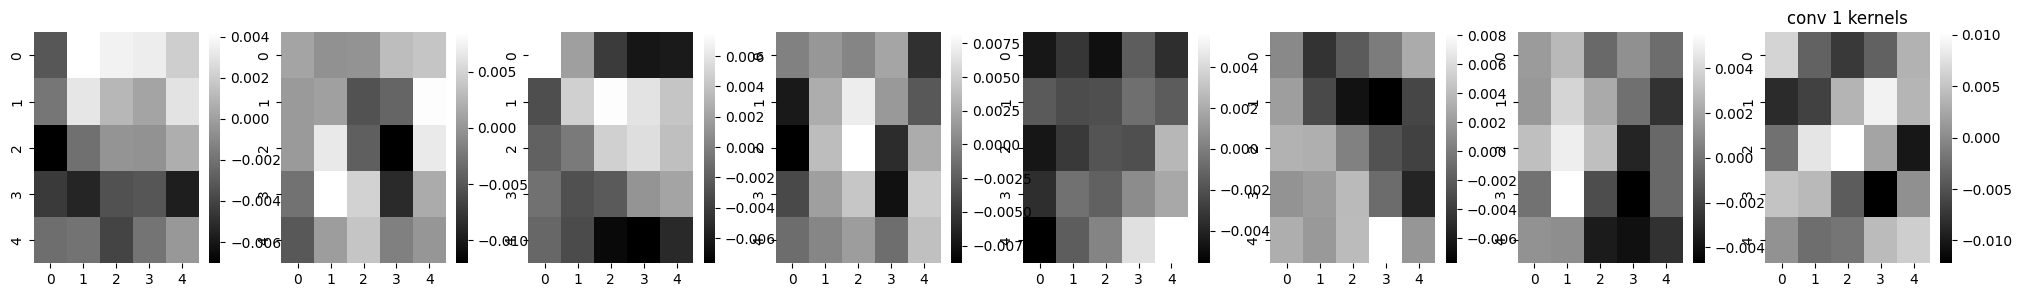

In [31]:
k = model.conv1.conv1_x.weight.detach().cpu().numpy()

fig, axs = plt.subplots(1, len(k), figsize=(25, 3))
plt.title('conv 1 kernels')
for i in range(len(k)):
    sns.heatmap(k[i].squeeze(), ax=axs[i], cmap='gray')
plt.show()

(16, 8, 5, 5)


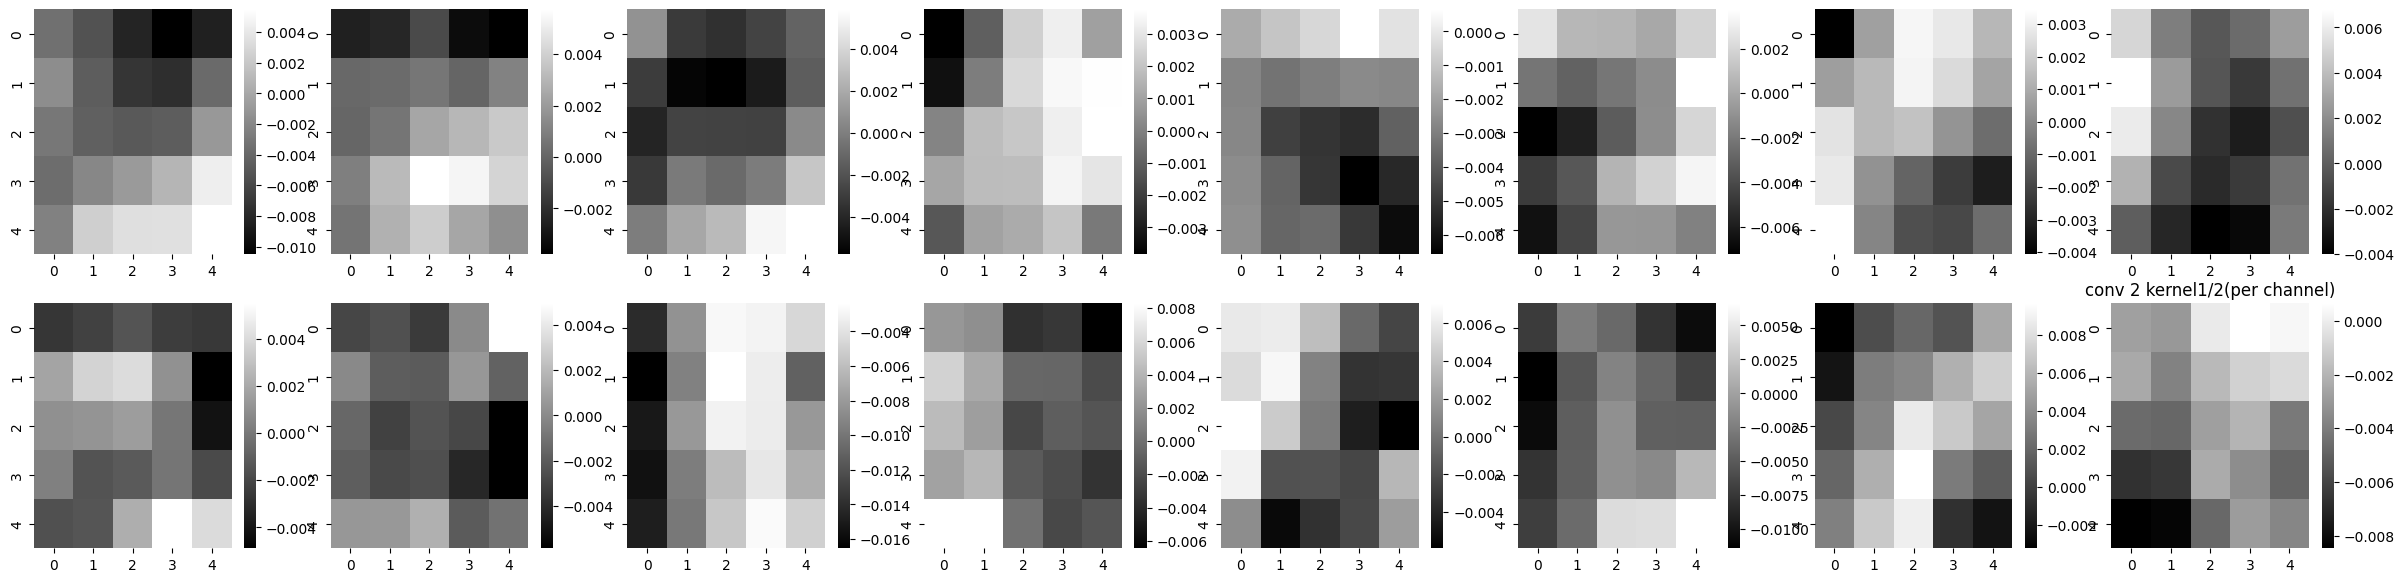

In [32]:
k = model.conv2.conv1_x.weight.detach().cpu().numpy()

print(k.shape)

fig, axs = plt.subplots(2, 8, figsize=(30, 7))
plt.title('conv 2 kernel1/2(per channel)')
for i in range(len(k[0])):
    sns.heatmap(k[0][i], ax=axs[0][i], cmap='gray')
    sns.heatmap(k[1][i], ax=axs[1][i], cmap='gray')
plt.show()

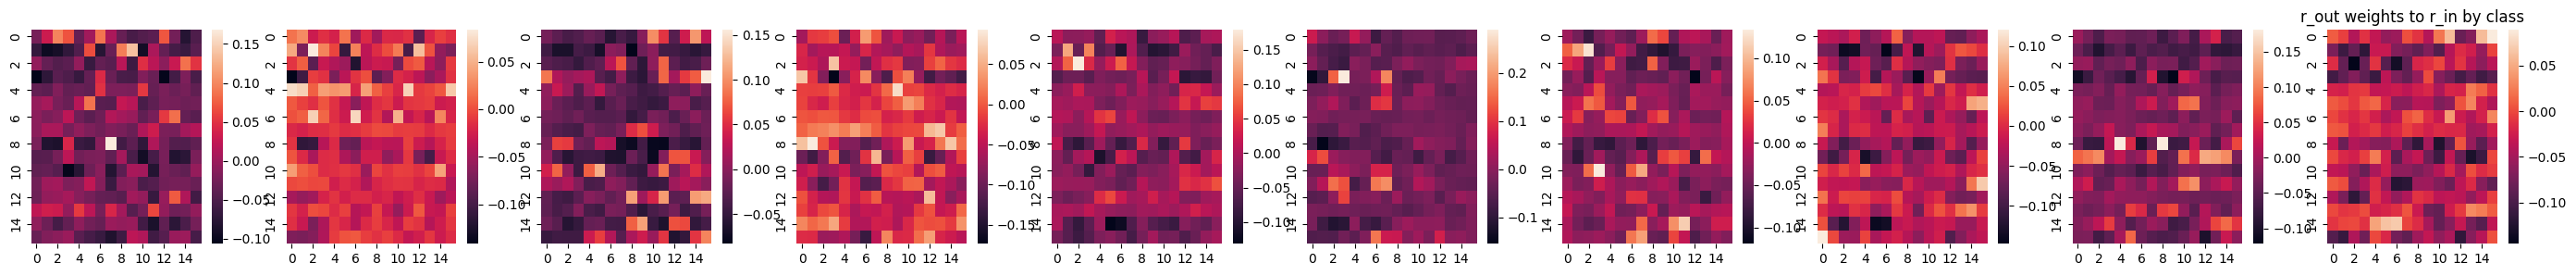

In [33]:
# plot p to r weights
fig, axs = plt.subplots(1, 10, figsize=(35, 3))
for i in range(10):
    sns.heatmap(
        model.pc_layer.rout2rin.weight[:, num_readout * i:(i + 1) * num_readout].detach().cpu().numpy().sum(axis=1).reshape(16, 16),
        ax=axs[i])
plt.title('r_out weights to r_in by class')

plt.show()

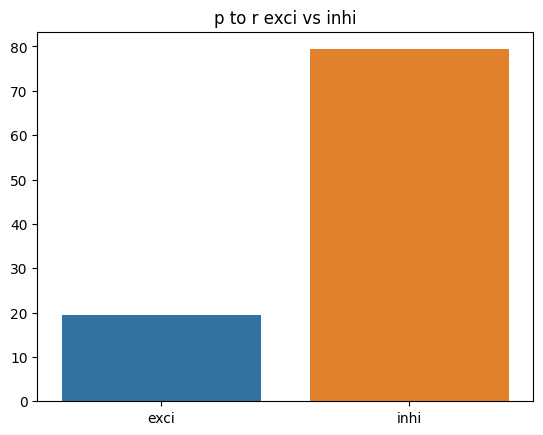

In [34]:
# plot p to r exci vs inhi
fig = plt.figure()
x = ['exci', 'inhi']
p2r_w = model.pc_layer.rout2rin.weight.detach().cpu().numpy()
y = [(p2r_w * (p2r_w > 0)).sum(), -(p2r_w * (p2r_w < 0)).sum()]
sns.barplot(x=x, y=y)
plt.title('p to r exci vs inhi')
plt.show()